# Phase estimation with CSS and SSS

In [12]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import qiskit as qis
import qiskit.quantum_info as qi
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.linalg import expm

service = QiskitRuntimeService(channel="local")

In [13]:
def collective_spin_operator(N: int, axis: int) -> qi.SparsePauliOp:
    """
    Construct the collective spin operator Jx, Jy, or Jz
    for an N-qubit spin-1/2 system using SparsePauliOp.

    Args:
        N (int): Number of qubits (spins)
        axis (str): Spin axis, one of {1, 2, 3} for {'x', 'y', 'z'}

    Returns:
        SparsePauliOp: The collective spin operator (J_axis)
    """

    # Pauli character for axis
    axis_map = {1: "X", 2: "Y", 3: "Z"}
    pauli_char = axis_map[axis]

    # Build operator: J_axis = (1/2) * Σ_i σ_axis^(i)
    total_op = 0 * qi.SparsePauliOp("I" * N)
    for i in range(N):
        pauli_str = ["I"] * N
        pauli_str[i] = pauli_char
        total_op += 0.5 * qi.SparsePauliOp("".join(pauli_str))
    return total_op


def maa_basis_unitary(N: int, axis: int) -> UnitaryGate:
    """
    Compute the unitary that transforms to the Maa squeezed-state eigenbasis.

    Args:
        N (int): Number of qubits (spins)
        axis (str): Axis along which the total spin operator is computed (1, 2, 3)

    Returns:
        UnitaryGate: Qiskit UnitaryGate transforming to Maa eigenbasis
    """
    # Get collective operator as dense matrix

    axis_map = {1: "X", 2: "Y", 3: "Z"}
    pauli_char = axis_map[axis]
    J_axis = collective_spin_operator(N, axis).to_matrix()

    # Compute eigenvectors (columns form unitary transformation)
    _, eigenvectors = np.linalg.eigh(J_axis)

    # Ensure eigenvectors form a proper unitary (orthonormal columns)
    if not np.allclose(eigenvectors.conj().T @ eigenvectors, np.eye(2**N),
                       atol=1e-10):
        raise ValueError(
            "Eigenvectors do not form a unitary basis. Numerical instability detected."
        )

    # Create a Qiskit UnitaryGate
    return UnitaryGate(eigenvectors, label=f"MaaBasis_N{N}_{pauli_char}")


def total_spin_operator(N, direction):
    dirs = 'IXYZ'
    op = 0 * qi.SparsePauliOp('I' * N)  # start with zero operator
    for i in range(N):
        pauli_str = ''.join(
            [dirs[0] if j != i else dirs[direction] for j in range(N)])
        op += 0.5 * qi.SparsePauliOp(pauli_str)
    return op

In [14]:
def squeezing_gate(N: int) -> UnitaryGate:
    """
    Construct the One-Axis Twisting (OAT) spin-squeezing gate:
        U = exp(-i * (mu/2) * (Jx')^2)
    where Jx' = e^{i δ Jz} Jx e^{-i δ Jz}.
    """

    mu = (24)**(1 / 6) * (N / 2)**(-2 / 3)
    A = 1 - np.cos(mu)**(N - 2)
    B = 4 * np.sin(mu / 2) * np.cos(mu / 2)**(N - 2)
    delta = 0.5 * np.arctan2(B, A)  # handles A=0 safely
    chi = mu / 2

    #  collective operators
    Jx = total_spin_operator(N, 1).to_matrix()
    Jz = total_spin_operator(N, 3).to_matrix()

    # rotated Jx' = e^{i δ Jz} Jx e^{-i δ Jz}
    rot = expm(1j * delta * Jz)
    Jx_rot = rot @ Jx @ rot.conj().T

    #  squeezing unitary
    U_sqz = expm(-1j * chi * (Jx_rot @ Jx_rot))
    return UnitaryGate(U_sqz, label=f"OAT_SQZ_{N}")

# CSS

We start just generating a coherent state in the $z$-axis direction, $|1\rangle ^{\otimes N}$, and measure the total $S_x$ spin, which is equivalent to measure all the individual qubit spins in the $x$ direction and add them (we will do the sum after running the circuit).

To measure the spin of individual qubits in each direction, we follow ```https://docs.quantum.ibm.com/guides/specify-observables-pauli```

In [15]:
def PM(N, dir):  #Phase Measure
    PM = qis.QuantumCircuit(N)
    # since it's equivalent, we start in the state |0>^\tensor n
    for j in range(0, N):
        if dir == 2:
            PM.sdg(j)  #only form measuring sy
        if dir == 1 or dir == 2:
            PM.h(j)  #measure sx or sy
    PM.measure_all()
    return (PM)

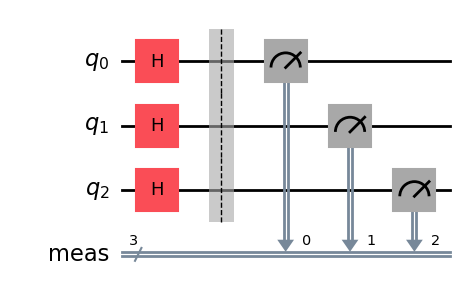

In [16]:
PM(3,1).draw("mpl")

# SSS

Now we generate the squeezed spin state of Kitagawa and Ueda (one-axis twisting or
OAT).
We do the squeezing in the $x$ direction, from the coherent state pointing along the $z$ axis.
But, to assure that the minimal and maximal variance occur when measuring $S_x$ and $S_y$, we
rotate the operator in the squeezing Hamiltonian by the twisting angle $-\delta$

In [17]:
# Now we measure Sx, Sy or Sz (depending on dir=1,2,3) in every qubit of the squeezed spin state, obtained by
# applying the squeezing operator to the CSS |0> ^{tensor N)
def SPM(N,dir):
    SPM = qis.QuantumCircuit(N) #Squeezed Phase Measure
    SPM.append(squeezing_gate(N),range(0,N)) #squeezing
    for j in range(0,N):
        if dir == 2:
            SPM.sdg(j) #only form measuring sy
        if dir == 1 or dir==2:
            SPM.h(j) #measure sx or sy
    SPM.measure_all()
    return(SPM)

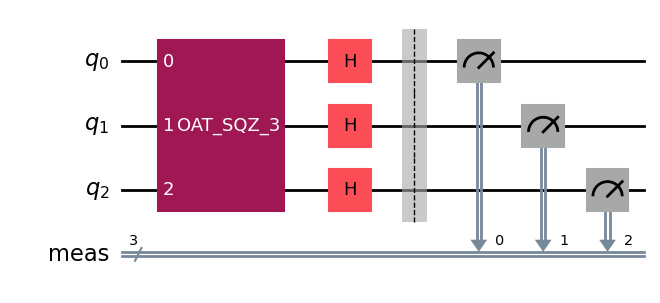

In [18]:
SPM(3,1).draw("mpl")

## Running the circuit


Let us get a histogram/variance of the circuits.

In [19]:
def run_css(N: int, direction: str, shots: int = 1024):
    """
    Run the CSS preparation circuit PM(N, direction) on AerSimulator,
    return variance of spin projection and counts distribution.
    """
    # Build and transpile circuit
    aer_sim = AerSimulator()
    circuit = PM(N, direction)
    transpiled = qis.transpile(circuit, aer_sim)

    # Run simulation
    result = aer_sim.run(transpiled, shots=shots, memory=True).result()
    data = np.array(result.get_memory())  # array of bitstrings

    # Convert bitstrings to "magnetization" values efficiently
    # Count number of '0's per shot → vectorized
    zero_counts = np.char.count(data, '0')
    magnetizations = N / 2 - zero_counts

    # Compute variance using NumPy (faster for large data)
    var = float(np.var(magnetizations, ddof=1))  # unbiased estimator

    # Count frequency distribution of magnetization outcomes
    counts = Counter(magnetizations)

    return var, counts


In [20]:
def run_sss(N: int, direction: str, shots: int = 1024):
    """
    Simulate the Spin-Squeezed State (SSS) circuit SPM(N, direction)
    on AerSimulator, returning the variance and measurement counts.

    Args:
        N (int): number of qubits (spins)
        direction (str): measurement direction ('x', 'y', 'z', etc.)
        shots (int): number of measurement shots

    Returns:
        tuple[float, Counter]:
            variance of spin projection,
            histogram of magnetization outcomes
    """
    aer_sim = AerSimulator()
    circuit = SPM(N, direction)
    transpiled = qis.transpile(circuit, aer_sim)

    # Run simulator
    result = aer_sim.run(transpiled, shots=shots, memory=True).result()
    data = np.array(result.get_memory())  # array of bitstrings

    # Efficiently compute number of zeros (vectorized)
    zero_counts = np.char.count(data, '0')
    magnetizations = N / 2 - zero_counts  # spin projection

    # Use NumPy for variance (fast for large datasets)
    var = float(np.var(magnetizations, ddof=1))  # sample variance

    # Count frequency of each magnetization value
    counts = Counter(magnetizations)

    return var, counts


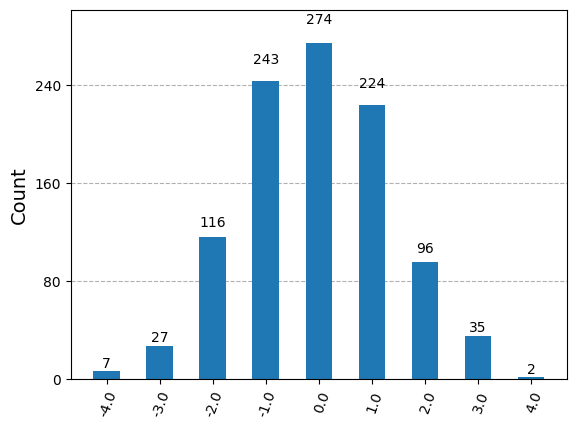

In [21]:
_, counts_css = run_css(8,1,1024)
plot_histogram(counts_css)

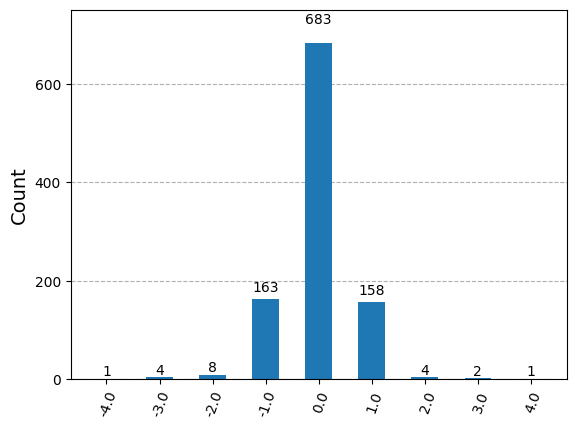

In [22]:
_, counts_sss = run_sss(8,1,1024)
plot_histogram(counts_sss)

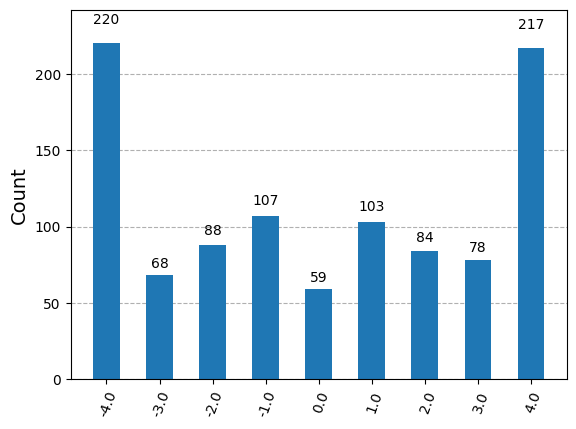

In [23]:
_, counts = run_sss(8,2,1024)
plot_histogram(counts)

Now we obtain and graphically compare the experimental variance for CSS and SSS and compare with the theoretical values that we had

In [24]:
N=14 #for larger N, SSS takes too long
var, varsqx = [], []
for j in range(1,N):
    variance_css, _ = run_css(j,1,1024)
    variance_sss, _ = run_sss(j,1,1024)
    var.append(variance_css/j**2)
    varsqx.append(variance_sss/j**2)

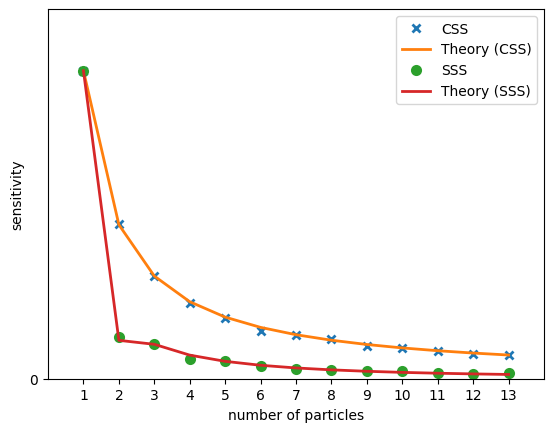

In [25]:
x_axis=np.arange(1, N)
th_var=1/(4*x_axis)
th_varsq=np.zeros_like(x_axis, dtype=float)
for i in range(1,N):
    mu = (24)**(1/6)*(i/2)**(-2/3)
    A = 1-np.cos(mu)**(i-2)
    B = 4*np.sin(mu/2)*np.cos(mu/2)**(i-2)
    th_varsq[i-1] = i/4*(1+(i-1)/4*(A-(A**2+B**2)**(1/2)))/(i**2)
_, ax = plt.subplots()
ax.plot(x_axis, var, 'x', markeredgewidth=2, label="CSS")
ax.plot(x_axis, th_var, linewidth=2.0, label="Theory (CSS)")
ax.plot(x_axis, varsqx, 'o', markeredgewidth=2, label="SSS")
ax.plot(x_axis, th_varsq, linewidth=2.0, label="Theory (SSS)")
plt.xlabel("number of particles")
plt.ylabel("sensitivity")
ax.set(xlim=(0, 14), xticks=np.arange(1, 14),
       ylim=(0, 0.3), yticks=np.arange(0, 0.5))
plt.legend()
plt.show()